# 1. Setup cfg, Datamodule, net

In [1]:
from omegaconf import OmegaConf
from hydra.utils import instantiate

cfg_file = '/home/xihe/xinhe/hyperbox_app/hyperbox_app/distributed/logs/runs/normal_search_nb201/search_nb201_gpunum1_c10_8net_1batch/2022-04-27_12-28-37/.hydra/config.yaml'
cfg = OmegaConf.load(cfg_file)

In [2]:
datamodule_cfg = cfg.datamodule
datamodule_cfg.batch_size = 256
datamodule = instantiate(datamodule_cfg)
datamodule.setup()
datamodule

/datasets/xihe/miniconda3/envs/hyperbox/lib/python3.7/site-packages/pytorch_lightning/core/datamodule.py:115: LightningDeprecationWarning: DataModule property `train_transforms` was deprecated in v1.5 and will be removed in v1.7.
  "DataModule property `train_transforms` was deprecated in v1.5 and will be removed in v1.7."
/datasets/xihe/miniconda3/envs/hyperbox/lib/python3.7/site-packages/pytorch_lightning/core/datamodule.py:134: LightningDeprecationWarning: DataModule property `val_transforms` was deprecated in v1.5 and will be removed in v1.7.
  "DataModule property `val_transforms` was deprecated in v1.5 and will be removed in v1.7."
/datasets/xihe/miniconda3/envs/hyperbox/lib/python3.7/site-packages/pytorch_lightning/core/datamodule.py:153: LightningDeprecationWarning: DataModule property `test_transforms` was deprecated in v1.5 and will be removed in v1.7.
  "DataModule property `test_transforms` was deprecated in v1.5 and will be removed in v1.7."


In [3]:
test_dataloader = datamodule.test_dataloader()
test_dataloader

# 2. Model

In [4]:
from hyperbox_app.distributed.networks.nasbench201 import NASBench201Network
from hyperbox.mutator import RandomMutator
from copy import deepcopy
import torch
import skdim
import numpy as np
import json
import itertools
from glob import glob
from hyperbox_app.distributed.engine.fewshot_search import lid_term_torch
from hyperbox.utils.utils import save_arch_to_json, load_json

from matplotlib import pyplot as plt
%matplotlib inline

In [5]:
torch.cuda.is_available()

False

In [6]:
net = NASBench201Network()
rm = RandomMutator(net)
rm.reset()

{'0_1': tensor([False, False, False, False,  True]),
 '0_2': tensor([False, False, False, False,  True]),
 '1_2': tensor([False, False, False,  True, False]),
 '0_3': tensor([False, False,  True, False, False]),
 '1_3': tensor([ True, False, False, False, False]),
 '2_3': tensor([False, False, False, False,  True])}

In [ ]:
file = '/home/xihe/xinhe/hyperbox_app/hyperbox_app/distributed/networks/nasbench201/all_masks.json'
with open(file, 'r') as f:
    all_masks = json.load(f)
keys = list(all_masks.keys())
len(all_masks), keys[:10], all_masks[keys[0]]

(15625,
 ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'],
 {'acc': 94.37333333333333,
  'arch': {'0_1': 'conv_3x3',
   '0_2': 'conv_3x3',
   '0_3': 'skip_connect',
   '1_2': 'conv_3x3',
   '1_3': 'conv_3x3',
   '2_3': 'conv_1x1'},
  'mask': {'0_1': [False, False, True, False, False],
   '0_2': [False, False, True, False, False],
   '0_3': [False, False, False, False, True],
   '1_2': [False, False, True, False, False],
   '1_3': [False, False, True, False, False],
   '2_3': [False, False, False, True, False]}})

In [7]:
def list2tensor(mask: dict):
    for key in mask:
        mask[key] = torch.tensor(mask[key])
    return mask

def get_IDs(mask, ckpt_path, dataloader=test_dataloader, model=net, mutator=rm):
    model.eval()
    mutator.sample_by_mask(list2tensor(mask))
    subnet = model.build_subnet(mask)
    subnet.load_from_ckpt(ckpt_path)
    IDs = []
    for i, (x, y) in enumerate(dataloader):
        if i == 5:
            break
        with torch.no_grad():
            crt_IDs = []
            outputs = subnet(x)
            feats = subnet.features
            for feat in feats:
                feat = feat.view(feat.shape[0], -1)
                ID = lid_term_torch(feat, feat)
                crt_IDs.append(ID)
            IDs.append(crt_IDs)
    IDs = np.mean(IDs, axis=0)
    return IDs

In [ ]:
mask_jsons = glob(f"/home/xihe/xinhe/hyperbox_app/hyperbox_app/distributed/logs/runs/3110541/runs/fine*/*/*.json")
mask_jsons = sorted(mask_jsons, key=lambda x: int(x.split('finetune_')[-1].split('_')[0]))
len(mask_jsons), mask_jsons[:5]

(50,
 ['/home/xihe/xinhe/hyperbox_app/hyperbox_app/distributed/logs/runs/3110541/runs/finetune_0_0/2022-07-09_04-57-28/0_94.3733.json',
  '/home/xihe/xinhe/hyperbox_app/hyperbox_app/distributed/logs/runs/3110541/runs/finetune_1_318/2022-07-09_04-56-42/318_93.6033.json',
  '/home/xihe/xinhe/hyperbox_app/hyperbox_app/distributed/logs/runs/3110541/runs/finetune_2_636/2022-07-09_10-27-21/636_93.3500.json',
  '/home/xihe/xinhe/hyperbox_app/hyperbox_app/distributed/logs/runs/3110541/runs/finetune_3_955/2022-07-09_08-37-38/955_93.2000.json',
  '/home/xihe/xinhe/hyperbox_app/hyperbox_app/distributed/logs/runs/3110541/runs/finetune_4_1273/2022-07-09_10-27-41/1273_93.0700.json'])

In [ ]:
infos = {}

for idx, mask_json in enumerate(mask_jsons):
    # if idx == 2:
    #     break    
    try:
        relative_path = mask_json.split('/2022')[0]
        ckpt_path = glob(f"{relative_path}/*/check*/last.ckpt")[0]
        print(ckpt_path)
        with open(mask_json, 'r') as f:
            mask = json.load(f)
        IDs = get_IDs(mask, ckpt_path)
        sort_idx = mask_json.split('finetune')[-1].split('_')[1]
        real_acc = mask_json.split('finetune')[-1].split('_')[-1].replace('.json', '')
        print(sort_idx, real_acc)
        infos[idx] = {'mask': mask, 'IDs': IDs, 'sort_idx': int(sort_idx), 'real_acc': float(real_acc)}
    except Exception as e:
        print(e)
    finally:
        torch.save(infos, '/home/xihe/xinhe/hyperbox_app/hyperbox_app/distributed/scripts/fewshot/finetune_masks/infosv2.pth')


/home/xihe/xinhe/hyperbox_app/hyperbox_app/distributed/logs/runs/3110541/runs/finetune_0_0/2022-07-09_04-57-28/checkpoints/last.ckpt
0 94.3733
/home/xihe/xinhe/hyperbox_app/hyperbox_app/distributed/logs/runs/3110541/runs/finetune_1_318/2022-07-09_04-56-42/checkpoints/last.ckpt
1 93.6033
/home/xihe/xinhe/hyperbox_app/hyperbox_app/distributed/logs/runs/3110541/runs/finetune_2_636/2022-07-09_10-27-21/checkpoints/last.ckpt
2 93.3500
/home/xihe/xinhe/hyperbox_app/hyperbox_app/distributed/logs/runs/3110541/runs/finetune_3_955/2022-07-09_08-37-38/checkpoints/last.ckpt
3 93.2000
/home/xihe/xinhe/hyperbox_app/hyperbox_app/distributed/logs/runs/3110541/runs/finetune_4_1273/2022-07-09_10-27-41/checkpoints/last.ckpt
4 93.0700
/home/xihe/xinhe/hyperbox_app/hyperbox_app/distributed/logs/runs/3110541/runs/finetune_5_1591/2022-07-09_06-37-48/checkpoints/last.ckpt
5 92.9200
/home/xihe/xinhe/hyperbox_app/hyperbox_app/distributed/logs/runs/3110541/runs/finetune_6_1910/2022-07-09_10-27-51/checkpoints/last

In [8]:
infos = torch.load('/home/xihe/xinhe/hyperbox_app/hyperbox_app/distributed/scripts/fewshot/finetune_masks/infosv2.pth')
print(len(infos))

50


In [ ]:
trained_idx = [val['sort_idx'] for val in infos.values()]
for idx in real_maps:
    if idx not in trained_idx:
        print(idx, real_maps[idx])

2865 9
10824 34


In [9]:
def plot_ids_by_layers(
    model_ids, figsize=(8,8), topk=None, divide_idx=None, disable_label=None, only_mean=False, filename=None,
    legend_loc=(1.15, 1.0), fontsize=16, debug=False, **kwargs):
    '''
    Args:
        model_ids: dict. {
            0: {'acc': 0.9288, 'IDs': [13,14,18,35,45,32,16,12,5]},
            1: {'acc': 0.9365, 'IDs': [...]},
            ...
        }
    '''
    import random
    import itertools
    from matplotlib import pyplot as plt
    from ipdb import set_trace
    if debug: set_trace()
    markers = itertools.cycle(('+', '<',  'd', 'h', 'H','1', '.', '2', 'D', 'o', '*', 'v', '>')) 
    fig = plt.figure(num=1,figsize=figsize)
    ax = fig.add_subplot(111)
    for key, value in model_ids.items():
        if topk is not None and key > topk:
            break
        label, IDs = value['real_acc'], value['IDs']
        label = f"{key}_{label:.2f}"
        y_axis = IDs
        marker = None
        if divide_idx is not None:
            if key <= divide_idx:
                color = '#2878b5'
                marker = '+'
                label = 'good'
            else:
                color = '#c82423'
                marker = 'd'
                label = 'bad'
        else:
            color = (random.random(), random.random(), random.random())
        # print(x_axis, y_axis)
        if disable_label:
            label = None
        if len(np.array(y_axis).shape) == 1:
            x_axis = np.array(list(range(len(IDs))))/(len(IDs)-1)
            if marker is None: marker = next(markers)
            ax.plot(x_axis, y_axis, marker=marker, label=label, color=color)
        else:
            num = np.array(y_axis).shape[1]
            x_axis = np.array(list(range(num)))/(num-1)
            y_axis_lb = y_axis.min(0)
            y_axis_ub = y_axis.max(0)
            y_axis_mean = y_axis.mean(0)
            if marker is None: marker = next(markers)
            if not only_mean:
                ax.plot(x_axis, y_axis_lb, marker=marker, color=color)
                ax.plot(x_axis, y_axis_ub, color=color, marker=marker)
                ax.fill_between(x_axis, y_axis_lb, y_axis_ub, color='gray', alpha=0.2)
                ax.plot(x_axis, y_axis_mean, color='red', marker=marker, label=label)
            else:
                ax.plot(x_axis, y_axis_mean, color=color, marker=marker, label=label)
    if divide_idx is None:
        ax.legend(loc='upper right', bbox_to_anchor=legend_loc, borderaxespad=0.)
    plt.xlabel('Relative depth', fontsize=16)
    plt.ylabel('ID', fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename)
    plt.show()


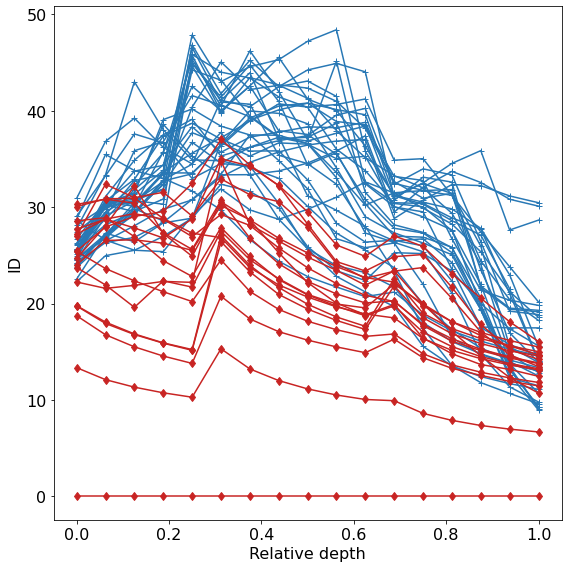

In [9]:
# print(infos)
plot_ids_by_layers(infos, divide_idx=32, disable_label=True, only_mean=True, filename='good_vs_bad.pdf')

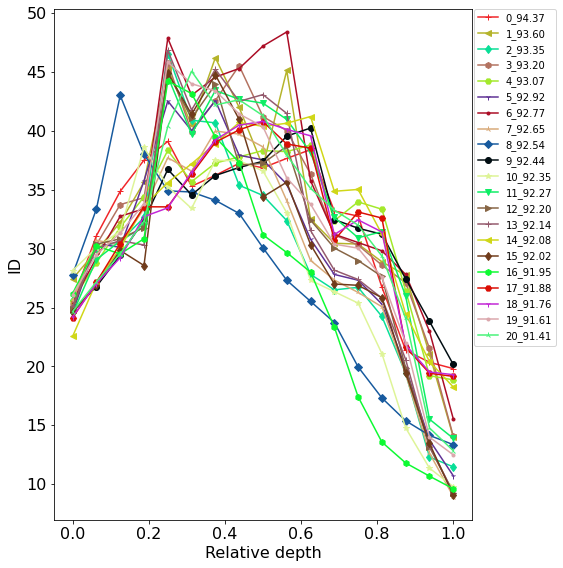

In [26]:
# print(infos)
plot_ids_by_layers(infos, topk=20, disable_label=False, only_mean=False, filename='good.pdf', legend_loc=(1.2, 1.0))

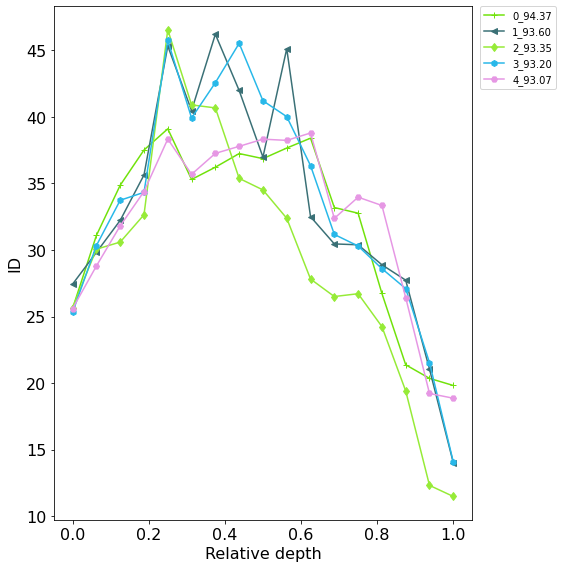

In [27]:

plot_ids_by_layers({key: infos[key] for key in range(5) if key in infos.keys() and key not in [8,16,6,17]}, topk=None, disable_label=False, only_mean=False, legend_loc=(1.2,1.0), filename='good.pdf')

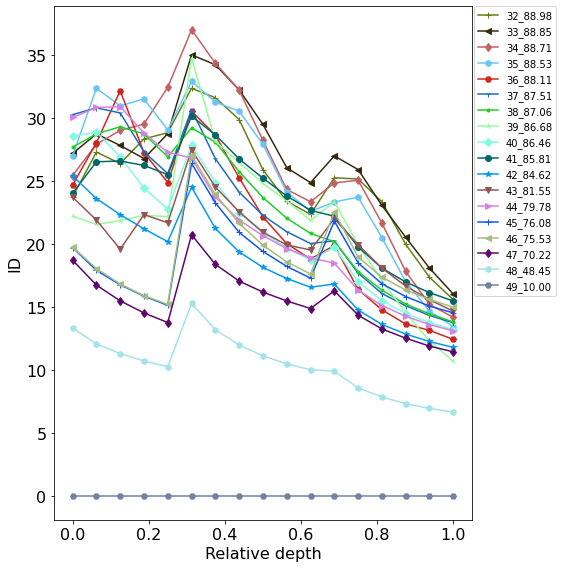

In [12]:

plot_ids_by_layers({key: infos[key] for key in range(32,50) if key in infos.keys()}, topk=None, disable_label=False, only_mean=True, legend_loc=(1.2,1.0), filename='bad.pdf')

In [18]:
4**10

1048576

In [ ]:
len(glob('/home/xihe/xinhe/hyperbox_app/hyperbox_app/distributed/scripts/fewshot/finetune_masks/*.json'))

50

In [ ]:
with open('/home/xihe/xinhe/hyperbox_app/hyperbox_app/distributed/networks/nasbench201/top1percent_models.json','r') as f:
    masks = json.load(f)
masks.keys()

dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155'])

In [ ]:
net = NASBench201Network()
rm = RandomMutator(net)
rm.reset()

{'0_1': tensor([ True, False, False, False, False]),
 '0_2': tensor([False,  True, False, False, False]),
 '1_2': tensor([False, False, False,  True, False]),
 '0_3': tensor([ True, False, False, False, False]),
 '1_3': tensor([False,  True, False, False, False]),
 '2_3': tensor([False, False, False,  True, False])}

In [ ]:
indices = [list(range(5)) for i in rm._cache]
indices = list(itertools.product(*indices))
print(len(indices), indices[0])

15625 (0, 0, 0, 0, 0, 0)


In [ ]:

accs = []
masks = {}
idx = 0

def index2mask(index, base_mask):
    mask = deepcopy(base_mask)
    for idx, key in enumerate(mask.keys()):
        encoding = torch.zeros_like(mask[key])
        encoding[index[idx]] = 1
        mask[key] = encoding.bool()
    return mask
index2mask(indices[1], rm._cache)

{'0_1': tensor([ True, False, False, False, False]),
 '0_2': tensor([ True, False, False, False, False]),
 '1_2': tensor([ True, False, False, False, False]),
 '0_3': tensor([ True, False, False, False, False]),
 '1_3': tensor([ True, False, False, False, False]),
 '2_3': tensor([False,  True, False, False, False])}

In [ ]:
idx = 0
masks = {}
accs = []
for index in indices:
    mask = index2mask(index, rm._cache)
    rm.sample_by_mask(mask)
    arch = net.arch
    acc = net.query_by_key()
    masks[idx] = {
        'acc': acc,
        'mask': mask,
        'arch': arch
    }
    idx += 1
    if idx % 1000 == 0:
        print(idx, "/15625")

1000 /15625
2000 /15625
3000 /15625
4000 /15625
5000 /15625
6000 /15625
7000 /15625
8000 /15625
9000 /15625
10000 /15625
11000 /15625
12000 /15625
13000 /15625
14000 /15625
15000 /15625


In [ ]:
sort_masks = sorted(masks.items(), key=lambda x: x[1]['acc'], reverse=True)
new_masks = {}
for idx in range(len(sort_masks)):
    new_masks[idx] = sort_masks[idx][1]

save_arch_to_json(new_masks, '/home/xihe/xinhe/hyperbox_app/hyperbox_app/distributed/networks/nasbench201/all_masks.json')

In [ ]:
indices = np.linspace(0,15600,num=50)
indices = [int(x) for x in indices]
print(indices)

[0, 318, 636, 955, 1273, 1591, 1910, 2228, 2546, 2865, 3183, 3502, 3820, 4138, 4457, 4775, 5093, 5412, 5730, 6048, 6367, 6685, 7004, 7322, 7640, 7959, 8277, 8595, 8914, 9232, 9551, 9869, 10187, 10506, 10824, 11142, 11461, 11779, 12097, 12416, 12734, 13053, 13371, 13689, 14008, 14326, 14644, 14963, 15281, 15600]


In [ ]:
for idx in indices:
    print(idx, new_masks[idx]['acc'])

0 94.37333333333333
318 93.60333333333334
636 93.35
955 93.19999999999999
1273 93.07
1591 92.92
1910 92.77333333333333
2228 92.64999999999999
2546 92.53999999999999
2865 92.44
3183 92.35
3502 92.27
3820 92.2
4138 92.13499999999999
4457 92.07666666666667
4775 92.02
5093 91.95
5412 91.87666666666667
5730 91.76
6048 91.61
6367 91.41333333333334
6685 91.27333333333333
7004 91.15333333333332
7322 91.035
7640 90.86666666666667
7959 90.57
8277 90.25333333333333
8595 90.05666666666667
8914 89.85
9232 89.63666666666666
9551 89.41000000000001
9869 89.15
10187 88.97666666666667
10506 88.84666666666668
10824 88.70666666666666
11142 88.52666666666669
11461 88.11
11779 87.50999999999999
12097 87.05999999999999
12416 86.68
12734 86.46000000000001
13053 85.80666666666667
13371 84.62
13689 81.55333333333334
14008 79.77666666666666
14326 76.075
14644 75.53
14963 70.225
15281 48.445
15600 10.0


In [ ]:
for i in range(50):
    idx = indices[i]
    mask = new_masks[idx]['mask']
    acc = new_masks[idx]['acc']
    save_arch_to_json(mask, f'/home/xihe/xinhe/hyperbox_app/hyperbox_app/distributed/scripts/fewshot/finetune_masks/{idx}_{acc:.4f}.json')

In [ ]:
from hyperbox.networks.utils import extract_net_from_ckpt
ckpt_file = '/home/xihe/xinhe/hyperbox_app/hyperbox_app/distributed/logs/runs/normal_search_nb201/search_nb201_gpunum1_c10_16net_1batch/2022-04-28_05-43-05/checkpoints/last.ckpt'
ckpt = torch.load(
    ckpt_file,
    map_location='cpu'
)
weight = extract_net_from_ckpt(ckpt_file)
net.load_state_dict(weight)


In [ ]:
len(infos)

50

In [7]:
import torch
import random
import numpy as np
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns

In [8]:
mask_IDs = torch.load('/home/xihe/xinhe/hyperbox_app/hyperbox_app/distributed/networks/nasbench201/all_masks_IDs.pt')
IDs = np.stack([v['IDs'] for v in mask_IDs.values()])

In [9]:
ID_embedded = TSNE(n_components=2, learning_rate='auto', init='random', verbose=True).fit_transform(IDs)
ID_embedded.shape

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 15625 samples in 0.001s...
[t-SNE] Computed neighbors for 15625 samples in 7.464s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15625
[t-SNE] Computed conditional probabilities for sample 2000 / 15625
[t-SNE] Computed conditional probabilities for sample 3000 / 15625
[t-SNE] Computed conditional probabilities for sample 4000 / 15625
[t-SNE] Computed conditional probabilities for sample 5000 / 15625
[t-SNE] Computed conditional probabilities for sample 6000 / 15625
[t-SNE] Computed conditional probabilities for sample 7000 / 15625
[t-SNE] Computed conditional probabilities for sample 8000 / 15625
[t-SNE] Computed conditional probabilities for sample 9000 / 15625
[t-SNE] Computed conditional probabilities for sample 10000 / 15625
[t-SNE] Computed conditional probabilities for sample 11000 / 15625
[t-SNE] Computed conditional probabilities for sample 12000 / 15625
[t-SNE] Computed conditional probabilities for sam

(15625, 2)

In [ ]:
accs = [v['acc'] for v in mask_IDs.values()]
np.mean(accs), np.median(accs), np.percentile(accs, 25), np.percentile(accs, 75), np.max(accs), np.min(accs)

(87.05633482666666, 90.73, 87.61500000000001, 92.185, 94.37333333333333, 10.0)

In [ ]:
keys = list(mask_IDs.keys())
keys[:2]

['0', '1']

In [ ]:
from sklearn.cluster import DBSCAN, SpectralClustering
from sklearn.mixture import GaussianMixture

In [ ]:

clustering = DBSCAN(eps=50, min_samples=50).fit(IDs)

In [ ]:
accs = np.array(accs)
best_mean = 0.
best_std = 1000
best_labels = None
best_n_cluster = -1

for n_cluster in range(2,17):
    gm = GaussianMixture(n_components=n_cluster, random_state=0, verbose=False, warm_start=True)
    for i in range(5):
        acc_labels = gm.fit_predict(IDs)
        mean_all = 0
        std_all = 0
        for x in set(acc_labels):
            crt_accs = accs[acc_labels==x]
            mean, std = crt_accs.mean(), crt_accs.std()
            mean_all += mean
            std_all += std
            # print(x, (acc_labels==x).sum(), mean, std)
        assert n_cluster>=len(set(acc_labels))
        mean_all/=len(set(acc_labels))
        std_all/=len(set(acc_labels))
        if std_all<best_std:
            best_mean = mean_all
            best_std = std_all
            best_labels = acc_labels
            best_n_cluster = n_cluster
            print(f"best n_cluster:{best_n_cluster} {best_mean}, {best_std}")
print(f"Final best n_cluster:{best_n_cluster} {best_mean}, {best_std}")
for x in set(best_labels):
    crt_accs = accs[acc_labels==x]
    mean, std = crt_accs.mean(), crt_accs.std()
    mean_all += mean
    std_all += std
    print(x, (acc_labels==x).sum(), mean, std)


best n_cluster:2 87.23446509353505, 13.912942811037864
best n_cluster:2 87.23543398363674, 13.91131075160068
best n_cluster:2 87.23476352835934, 13.9105630355597
best n_cluster:2 87.23519400334486, 13.909735096163145
best n_cluster:2 87.23594266389803, 13.908059116823098
best n_cluster:3 36.55176575157806, 5.46967800392975
best n_cluster:5 57.739310974160425, 4.300314339420519
best n_cluster:5 57.739336413554916, 4.300123452505296
best n_cluster:5 57.73037320735407, 4.296007543175849
best n_cluster:5 57.73034244500335, 4.295992486119163
best n_cluster:8 49.76126107319719, 3.1801596702640778
best n_cluster:14 55.60755520443446, 2.9760096186477667
best n_cluster:14 55.60760739800891, 2.9759861911760352
best n_cluster:15 52.56705152413883, 2.7776089774045825
best n_cluster:15 52.56710023814165, 2.7775871117642996
best n_cluster:16 54.98323153827167, 2.734533380589765
best n_cluster:16 54.98323755893494, 2.734385365408211
best n_cluster:16 54.983482447466116, 2.7342892844134465
best n_clus

In [ ]:
n_cluster = 4
gm = GaussianMixture(n_components=n_cluster, random_state=0, verbose=False, warm_start=True, max_iter=300)
acc_labels = gm.fit_predict(IDs)
for x in set(acc_labels):
    crt_accs = accs[acc_labels==x]
    mean, std = crt_accs.mean(), crt_accs.std()
    mean_all += mean
    std_all += std
    print(x, (acc_labels==x).sum(), mean, std)



0 3502 89.74452170188464 9.032012545251071
1 87 10.0 0.0
2 216 11.09050925925926 9.189680880985954
3 11820 88.21525944726453 6.5465059195743605


In [ ]:
n_cluster = 6
gm = GaussianMixture(n_components=n_cluster, random_state=0, verbose=False, warm_start=True, max_iter=300)
indices = acc_labels==3
acc_labels2 = gm.fit_predict(IDs[indices])
print(acc_labels2.shape)
for x in set(acc_labels2):
    crt_accs = accs[indices][acc_labels2==x]
    mean, std = crt_accs.mean(), crt_accs.std()
    mean_all += mean
    std_all += std
    print(x, (acc_labels2==x).sum(), mean, std)



(11820,)
0 9271 87.18973771258045 7.015353742247833
1 201 88.8439303482587 0.19098802665633527
2 470 91.71746808510638 1.8048499006496517
3 202 91.4826897689769 1.783263785545823
4 211 92.01733807266983 0.34451637382918615
5 1465 92.49713765642774 0.5390312646043615


In [ ]:
accs = np.array(accs)
best_mean = 0.
best_std = 100
best_labels = None
gm = GaussianMixture(n_components=4, random_state=0, verbose=False, warm_start=True)
for n_cluster in range(2,17):
    acc_labels = gm.fit_predict(IDs)
    # acc_labels = GaussianMixture(n_components=n_cluster, random_state=0, verbose=False, warm_start=True).fit_predict(IDs)
    print(f"{n_cluster}"+"="*20)
    mean_all = 0
    std_all = 0
    for x in set(acc_labels):
        crt_accs = accs[acc_labels==x]
        mean, std = crt_accs.mean(), crt_accs.std()
        mean_all += mean
        std_all += std
        print(x, (acc_labels==x).sum(), mean, std)
    mean_all/=len(set(acc_labels))
    std_all/=len(set(acc_labels))
    if std_all<best_std:
        best_mean = mean_all
        best_std = std_all
        best_labels = acc_labels
        print(f"best n_cluster{n_cluster}")
        print(mean_all, std_all)
# print(f"Final best n_cluster{n_cluster}")
# for x in set(best_labels):
#     crt_accs = accs[acc_labels==x]
#     print(x, (acc_labels==x).sum(), best_mean, best_std)

2====================
0 3502 89.74452170188464 9.032012545251071
1 87 10.0 0.0
2 216 11.09050925925926 9.189680880985954
3 11820 88.21525944726453 6.5465059195743605
best n_cluster2
49.76257260210211 6.1920498364528465
3====================
0 3503 89.74446331715671 9.030723931679555
1 87 10.0 0.0
2 216 11.09050925925926 9.189680880985954
3 11819 88.21514736159291 6.546771520872348
best n_cluster3
49.76252998450222 6.191794083384464
4====================
0 3508 89.74792426833905 9.024753185909054
1 87 10.0 0.0
2 216 11.09050925925926 9.189680880985954
3 11814 88.21347243383556 6.54764940114183
best n_cluster4
49.76297649035847 6.19052086700921
5====================
0 3513 89.75019166903881 9.01867186540505
1 87 10.0 0.0
2 216 11.09050925925926 9.189680880985954
3 11809 88.21214822028396 6.548660334368649
best n_cluster5
49.76321228714551 6.189253270189913
6====================
0 3514 89.75068677670271 9.01743627453262
1 87 10.0 0.0
2 216 11.09050925925926 9.189680880985954
3 11808 88.21

In [ ]:
tIDs = torch.from_numpy(IDs)
origin_distance = torch.cdist(tIDs, tIDs).numpy()
# distance = distance**0.5

In [ ]:
distance = (origin_distance - origin_distance.mean())/origin_distance.std()

In [ ]:
distance = origin_distance**0.2

In [ ]:
distance.mean(), np.percentile(distance, 10), np.percentile(distance, 75), distance.max(), distance.min()

(4.4869633, 1.7589900493621826, 6.8958740234375, 12.336267, 0.0)

In [ ]:
indices = np.where(acc_labels==0)
indices

(array([    5,     8,     9, ..., 14949, 14953, 15230]),)

In [ ]:
distance[:30,:30].mean()

1.3908552

In [ ]:
distance[-150:,-150:]

array([[0.       , 9.9720545, 9.916699 , ..., 0.       , 0.       ,
        0.       ],
       [9.9720545, 2.143547 , 9.173138 , ..., 9.9720545, 9.9720545,
        9.9720545],
       [9.916699 , 9.173138 , 2.143547 , ..., 9.916699 , 9.916699 ,
        9.916699 ],
       ...,
       [0.       , 9.9720545, 9.916699 , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 9.9720545, 9.916699 , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 9.9720545, 9.916699 , ..., 0.       , 0.       ,
        0.       ]], dtype=float32)

In [ ]:
from copy import deepcopy
best_score = 0
best_eps = -1
best_min_sample = -1
for eps in [1,1.3,2,3]:
    for min_sample in [50, 100, 150, 200]:
        std_all = 0
        score = 0
        mean_all = 0
        acc_labels = DBSCAN(eps=eps, min_samples=min_sample, metric='precomputed').fit_predict(distance)
        labels= deepcopy(acc_labels).astype('<U21')
        print('*'*20)
        print('\n')
        for x in set(acc_labels):
            crt_accs = accs[acc_labels==x]
            mean, std = crt_accs.mean(), crt_accs.std()
            mean_all += mean
            std_all += std
            print(x, (acc_labels==x).sum(), mean, std)
            labels[acc_labels==x] = f"{x} ({mean:.2f}±{std:.2f})"
            score += mean * (acc_labels==x).sum()
        std_all = std_all / len(set(acc_labels))
        
        if score>best_score:
            best_score = score
            best_std = std_all
            best_eps = eps
            best_min_sample = min_sample
            print('='*20)
            print("best", best_eps, best_min_sample, best_std, best_score/len(set(acc_labels)))
            print('\n')
            

********************


0 201 92.0138142620232 0.14522333992454162
1 83 91.12584337349398 0.1520873008766678
2 68 90.39178921568627 0.8953134750699708
3 85 88.83931372549019 0.21579815280207304
4 51 89.57454248366012 0.19255338462188534
5 59 89.6190395480226 0.1555208742112337
6 201 88.8439303482587 0.19098802665633527
7 242 86.53621900826447 0.1726325345358854
8 64 82.337734375 4.877680462939386
9 196 78.98882653061224 4.6681783217929915
10 68 78.11764705882354 4.3121598116773905
11 314 75.74168259023354 0.2557510997275137
12 121 75.69231404958677 0.2544895656447957
13 152 70.4877850877193 6.9429676935638405
14 84 67.62845238095238 5.952904529750584
15 201 10.0 0.0
-1 13435 88.9046363974693 9.451938833659897
best 1 50 2.2844816122032348 80015.01362745099


********************


0 201 92.0138142620232 0.14522333992454162
1 201 88.8439303482587 0.19098802665633527
2 242 86.53621900826447 0.1726325345358854
3 187 78.95057932263815 4.775167687832174
4 314 75.74168259023354 0.2557510997275

In [ ]:
print("best", best_eps, best_min_sample, best_std, best_score/len(set(acc_labels)))

best 1 200 1.7395500789153215 272051.04633333336


In [ ]:
acc_labels = DBSCAN(eps=1.5, min_samples=200, metric='precomputed').fit_predict(distance)
labels= deepcopy(acc_labels).astype('<U21')
for x in set(acc_labels):
    crt_accs = accs[acc_labels==x]
    mean, std = crt_accs.mean(), crt_accs.std()
    mean_all += mean
    std_all += std
    print(x, (acc_labels==x).sum(), mean, std)
    labels[acc_labels==x] = f"{x} ({mean:.2f}±{std:.2f})"

0 2928 90.67944273679417 2.7510350776096684
1 544 92.47113357843136 0.5357422445370905
2 6273 85.53040836388757 7.785339809677134
3 201 92.0138142620232 0.14522333992454162
4 201 88.8439303482587 0.19098802665633527
5 201 10.0 0.0
-1 5277 88.97988787821363 13.23702384858512


In [11]:
mask_IDs['1']

{'acc': 94.37333333333333,
 'arch': {'0_1': 'conv_3x3',
  '0_2': 'conv_3x3',
  '0_3': 'skip_connect',
  '1_2': 'conv_3x3',
  '1_3': 'conv_1x1',
  '2_3': 'conv_3x3'},
 'mask': {'0_1': [False, False, True, False, False],
  '0_2': [False, False, True, False, False],
  '0_3': [False, False, False, False, True],
  '1_2': [False, False, True, False, False],
  '1_3': [False, False, False, True, False],
  '2_3': [False, False, True, False, False]},
 'IDs': array([32.089363, 32.972206, 32.844856, 32.517647, 32.55501 , 39.555054,
        39.04007 , 38.982327, 38.972282, 38.969646, 38.96812 , 28.388601,
        28.388474, 28.388443, 28.38847 , 28.388449, 28.388453],
       dtype=float32)}

In [ ]:
from glob import glob
supernet_masks = glob('/home/xihe/xinhe/hyperbox_app/hyperbox_app/distributed/logs/runs/fewshot_search_nb201_c10_ID_mincut_fp_16splits_loadparent_1nets_sgdlr0.01/2022-07-20_01-40-55/checkpoints/*mask_json')

for key, val in mask_IDs.items():
    

Text(0, 0.5, 'Comp-1')

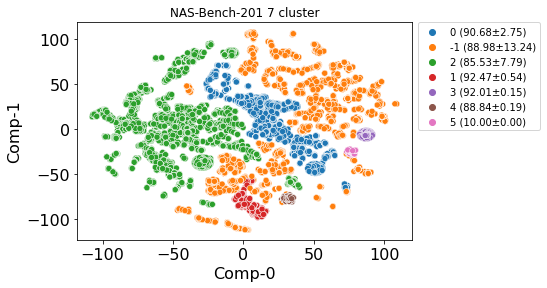

In [ ]:

df = pd.DataFrame()
df['x0'] = ID_embedded[:,0]
df['x1'] = ID_embedded[:,1]
df['y'] = np.array(labels)
n_cluster = len(set(acc_labels))
sns.scatterplot(x="x0", y="x1", hue=df.y.tolist(),
                palette=sns.color_palette(n_colors=n_cluster),
                data=df).set(title=f"NAS-Bench-201 {n_cluster} cluster") 
plt.legend(loc='upper center', borderaxespad=0., ncol=1, fontsize=10, bbox_to_anchor=(1.2,1.0))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Comp-0', fontsize=16)
plt.ylabel('Comp-1', fontsize=16)
# plt.tight_layout()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354)]

In [ ]:
indices = np.where(acc_labels==0)
indices

(array([    0,     1,     2, ..., 14949, 14953, 15230]),)

In [ ]:
indices = np.where(acc_labels==-1)
indices

(array([   76,   114,   137, ..., 15570, 15598, 15599]),)

In [ ]:
indices = np.where(acc_labels==2)
indices

(array([  139,   398,   483, ..., 15281, 15282, 15283]),)

In [2]:
import torch
IDs = torch.load('../IDs.pt')
grads = torch.load('../grads.pt')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
def showMatrix(matrix, vmin=0, vmax=1):
    # plt.imshow(matrix, cmap='gray', interpolation='none')
    plt.matshow(matrix, vmin=vmin, vmax=vmax) 
    plt.colorbar()
    plt.show()

In [4]:
def showPairByKey(grads=grads, IDs=IDs, vmin=0, vmax=0.5, figsize=(10,5)):
    keys = list(grads.keys())
    fig, axs = plt.subplots(nrows=2, ncols=len(keys), figsize=figsize)
    for idx, key in enumerate(keys):
        im = axs[0, idx].matshow(grads[key].numpy(), vmin=vmin, vmax=vmax)
        im = axs[1, idx].matshow(IDs[key].numpy(), vmin=vmin, vmax=vmax)

    fig.subplots_adjust(right=0.7)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    # plt.colorbar()
    plt.show()


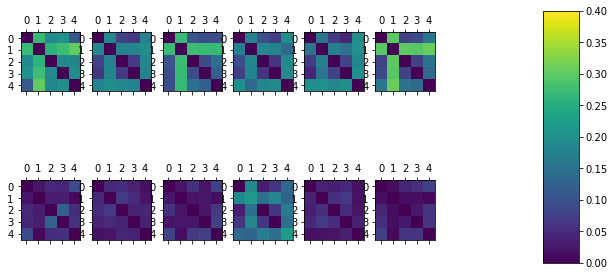

In [6]:
showPairByKey(vmax=0.4)


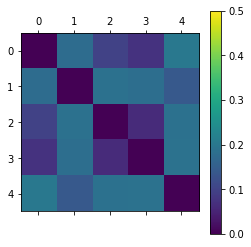

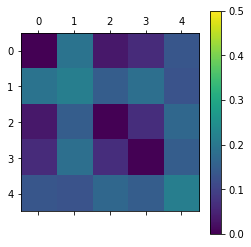

In [28]:
showPairByKey('0_3')

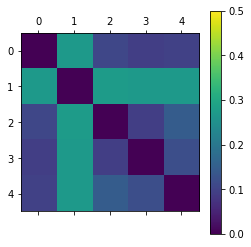

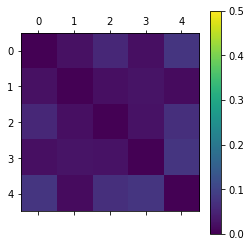

In [29]:
showPairByKey('1_2')

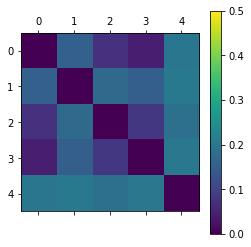

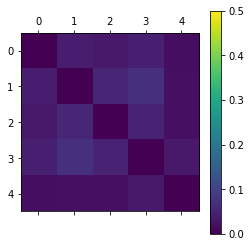

In [30]:
showPairByKey('1_3')

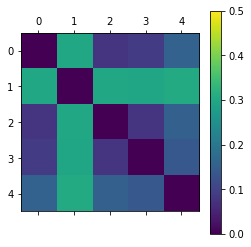

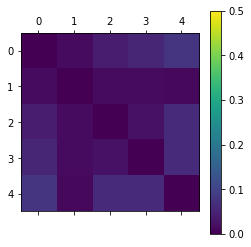

In [31]:
showPairByKey('2_3')

In [ ]:
for idx, (k,v) in enumerate(mask_IDs.items()):
    v['label'] = acc_labels[idx]
mask_IDs['0']

{'acc': 94.37333333333333,
 'arch': {'0_1': 'conv_3x3',
  '0_2': 'conv_3x3',
  '0_3': 'skip_connect',
  '1_2': 'conv_3x3',
  '1_3': 'conv_3x3',
  '2_3': 'conv_1x1'},
 'mask': {'0_1': [False, False, True, False, False],
  '0_2': [False, False, True, False, False],
  '0_3': [False, False, False, False, True],
  '1_2': [False, False, True, False, False],
  '1_3': [False, False, True, False, False],
  '2_3': [False, False, False, True, False]},
 'IDs': array([33.04086 , 33.72445 , 33.191963, 32.711765, 32.71195 , 40.18399 ,
        39.462456, 39.26576 , 39.194897, 39.160942, 39.138447, 29.136738,
        29.133646, 29.133083, 29.133099, 29.133068, 29.133038],
       dtype=float32),
 'label': 0}

In [ ]:
torch.save(mask_IDs, '/home/xihe/xinhe/hyperbox_app/hyperbox_app/distributed/networks/nasbench201/all_mask_IDs_dbscan.pt')

In [ ]:
set(acc_labels)

{-1, 0, 1, 2, 3, 4, 5}

In [ ]:
from